# Improvement Tester
This notebook enables testing of additional metrics based on graph properties.

## Setup

In [1]:
# Prepare the loading of Datasets
from os.path import join
from os import getcwd
import json
from tqdm import tqdm

from dataset.Dataset import Dataset
from experiments.Analyser import accuracy_based_on_jacard_index
from graph.SpreadSheetGraph import SpreadSheetGraph
from labelregions.LabelRegionLoader import LabelRegionLoader
from search.ExhaustiveSearch import ExhaustiveSearch
from search.FitnessRater import FitnessRater, get_initial_weights


DATA_DIR = join(getcwd(), "../data")
OUTPUT_DIR = join(getcwd(), "output_final/output")

refined_file_path = join(DATA_DIR, "Deco", "refined.json")
with open(refined_file_path) as f:
    refined_data = json.load(f)

relevant_keys = [key for key, value in refined_data.items()] #  if value["edge_count"] > 10]

DECO = Dataset(join(DATA_DIR, "Deco"), "Deco")
FUSTE = Dataset(join(DATA_DIR, "FusTe"), "FusTe")

loader = LabelRegionLoader()

In [2]:
# Load Deco
deco_graphs = []
for sheet in tqdm(DECO.get_sheet_data(loader), total=DECO.sheet_data_count()):
    deco_graphs.append(SpreadSheetGraph(sheet))

  6%|▋         | 40/622 [00:01<00:27, 21.21it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
 35%|███▌      | 220/622 [00:10<00:21, 18.79it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/reader/drawings.py:29: UserWarning: DrawingML support is incomplete and limited to charts and images only. Shapes and drawings will be lost.
  warn("DrawingML support is incomplete and limited to charts and images only. Shapes and drawings will be lost.")
 51%|█████     | 316/622 [00:15<00:09, 33.57it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/reader/drawings.py:55: UserWarning: The image xl/media/image1.emf will be removed because it cannot be read
  warn(msg)
 91%|█████████ | 566/622 [00:26<00:02, 25.57it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/reader/drawings.py:59: UserWarn

In [3]:
# Load FusTe
fuste_graphs = []
for sheet in tqdm(FUSTE.get_sheet_data(loader), total=FUSTE.sheet_data_count()):
    fuste_graphs.append(SpreadSheetGraph(sheet))

 21%|██▏       | 93/434 [00:04<00:17, 19.48it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 434/434 [00:20<00:00, 20.96it/s]


## Improvements
Here you can implement a potential improvement based on properties of the graph representations.

In [5]:
# Utility Methods

from labelregions.LabelRegionType import LabelRegionType
from graph.Edge import ConnectionType

def header_lrs(graph):
    """Returns all Header Label Regions of the given graph"""
    return list(filter(lambda x: x.type == LabelRegionType.HEADER, graph.nodes))

def data_lrs(graph):
    """Returns all Data Label Regions of the given graph"""
    return list(filter(lambda x: x.type == LabelRegionType.DATA, graph.nodes))

def density(graph):
    """Returns the denstiy of the given graph"""
    return (2 * len(graph.edge_list)) / (len(graph.nodes) * (len(graph.nodes) - 1))


def edges_type_count(graph, connection_type: ConnectionType):
    """Returns the cound of a specific edge type of the given graph"""
    return len([
        e
        for e in graph.edge_list
        if e.connection_type == connection_type
    ])

In [6]:
# Improvments and wrapper method

from graph.Edge import ConnectionType


def density_cut(graph):
    data = data_lrs(graph)
    header = header_lrs(graph)
    
    d_d = edges_type_count(graph, ConnectionType.D_D) + 1
    h_h = edges_type_count(graph, ConnectionType.H_H) + 1
    h_d = edges_type_count(graph, ConnectionType.D_H) + 1

    try:
        d_d_density = 2 * d_d / (len(data) * (len(data) - 1))
    except ZeroDivisionError:
        # No data or just one data region
        d_d_density = 1
    try:
        h_h_density = 2 * h_h / (len(header) * (len(header) - 1))
    except ZeroDivisionError:
        # No header or just one header region
        h_h_density = 1
    
    return d_d_density * h_h_density

def average_node_degree(graph):
    data = data_lrs(graph)
    header = header_lrs(graph)
    
    d_d = edges_type_count(graph, ConnectionType.D_D) + 1
    h_h = edges_type_count(graph, ConnectionType.H_H) + 1
    h_d = edges_type_count(graph, ConnectionType.D_H) + 1

    avg_node_degree = (d_d + h_h) / (len(data_lrs(graph)) + len(header_lrs(graph)))
    return avg_node_degree

def avg_degree_cut(graph):
    data = data_lrs(graph)
    header = header_lrs(graph)
    
    d_d = edges_type_count(graph, ConnectionType.D_D) + 1
    h_h = edges_type_count(graph, ConnectionType.H_H) + 1
    h_d = edges_type_count(graph, ConnectionType.D_H) + 1
    
    try:
        d_d_degree_avg = d_d / len(data_lrs(graph))
    except ZeroDivisionError:
        d_d_degree_avg = 0
    try:
        h_h_degree_avg = h_h / len(header_lrs(graph))
    except ZeroDivisionError:
        h_h_degree_avg = 0
    return d_d_degree_avg * h_h_degree_avg

def prediction_metric(graph):
    """This metric will be used for evaluation. Insert your code/method!"""
    return avg_degree_cut(graph)
    

In [22]:
# Improvement Visualization
import matplotlib.pyplot as plt
from statistics import mean, median
import math


def visualize_metric(edge_filter, title):

    single_agg = []
    multi_agg = []
    for g in graphs:
        if edge_filter(len(g.edge_list)):
            m = prediction_metric(g)
            if len(g.get_components()) == 1:
                single_agg.append(m)
            else:
                multi_agg.append(m)
    print(median(multi_agg))
    print(mean(multi_agg))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), dpi=1200)
    
    w = 0.1
    data_min = min([min(single_agg), min(multi_agg)])
    data_max = max([max(single_agg), max(multi_agg)])
    n = math.ceil((data_max - data_min)/w)

    ax1.hist(single_agg, label="single", alpha=0.5, bins=n)
    ax1.hist(multi_agg, label="multi", alpha=0.5, bins=n)
    ax1.legend()
    ax1.set_ylabel("Frequency")
    ax1.set_xlabel("Prediction Metric")

    ax2.boxplot([
            single_agg,
            multi_agg
        ],
        labels=["single", "multi"],
        vert=False,
        showmeans=True,
    )
    ax2.set_xlabel("Prediction Metric")
    fig.suptitle(title)

In [8]:
# Edge Count Filters
edges_b_10 = lambda x: x <= 10
edges_b_10_100 = lambda x: 10 < x <= 100
edges_a_100 = lambda x: x > 100
all_edges = lambda x: True

## Evaluation

### Visl

0.9393382352941176
1.062141526293403


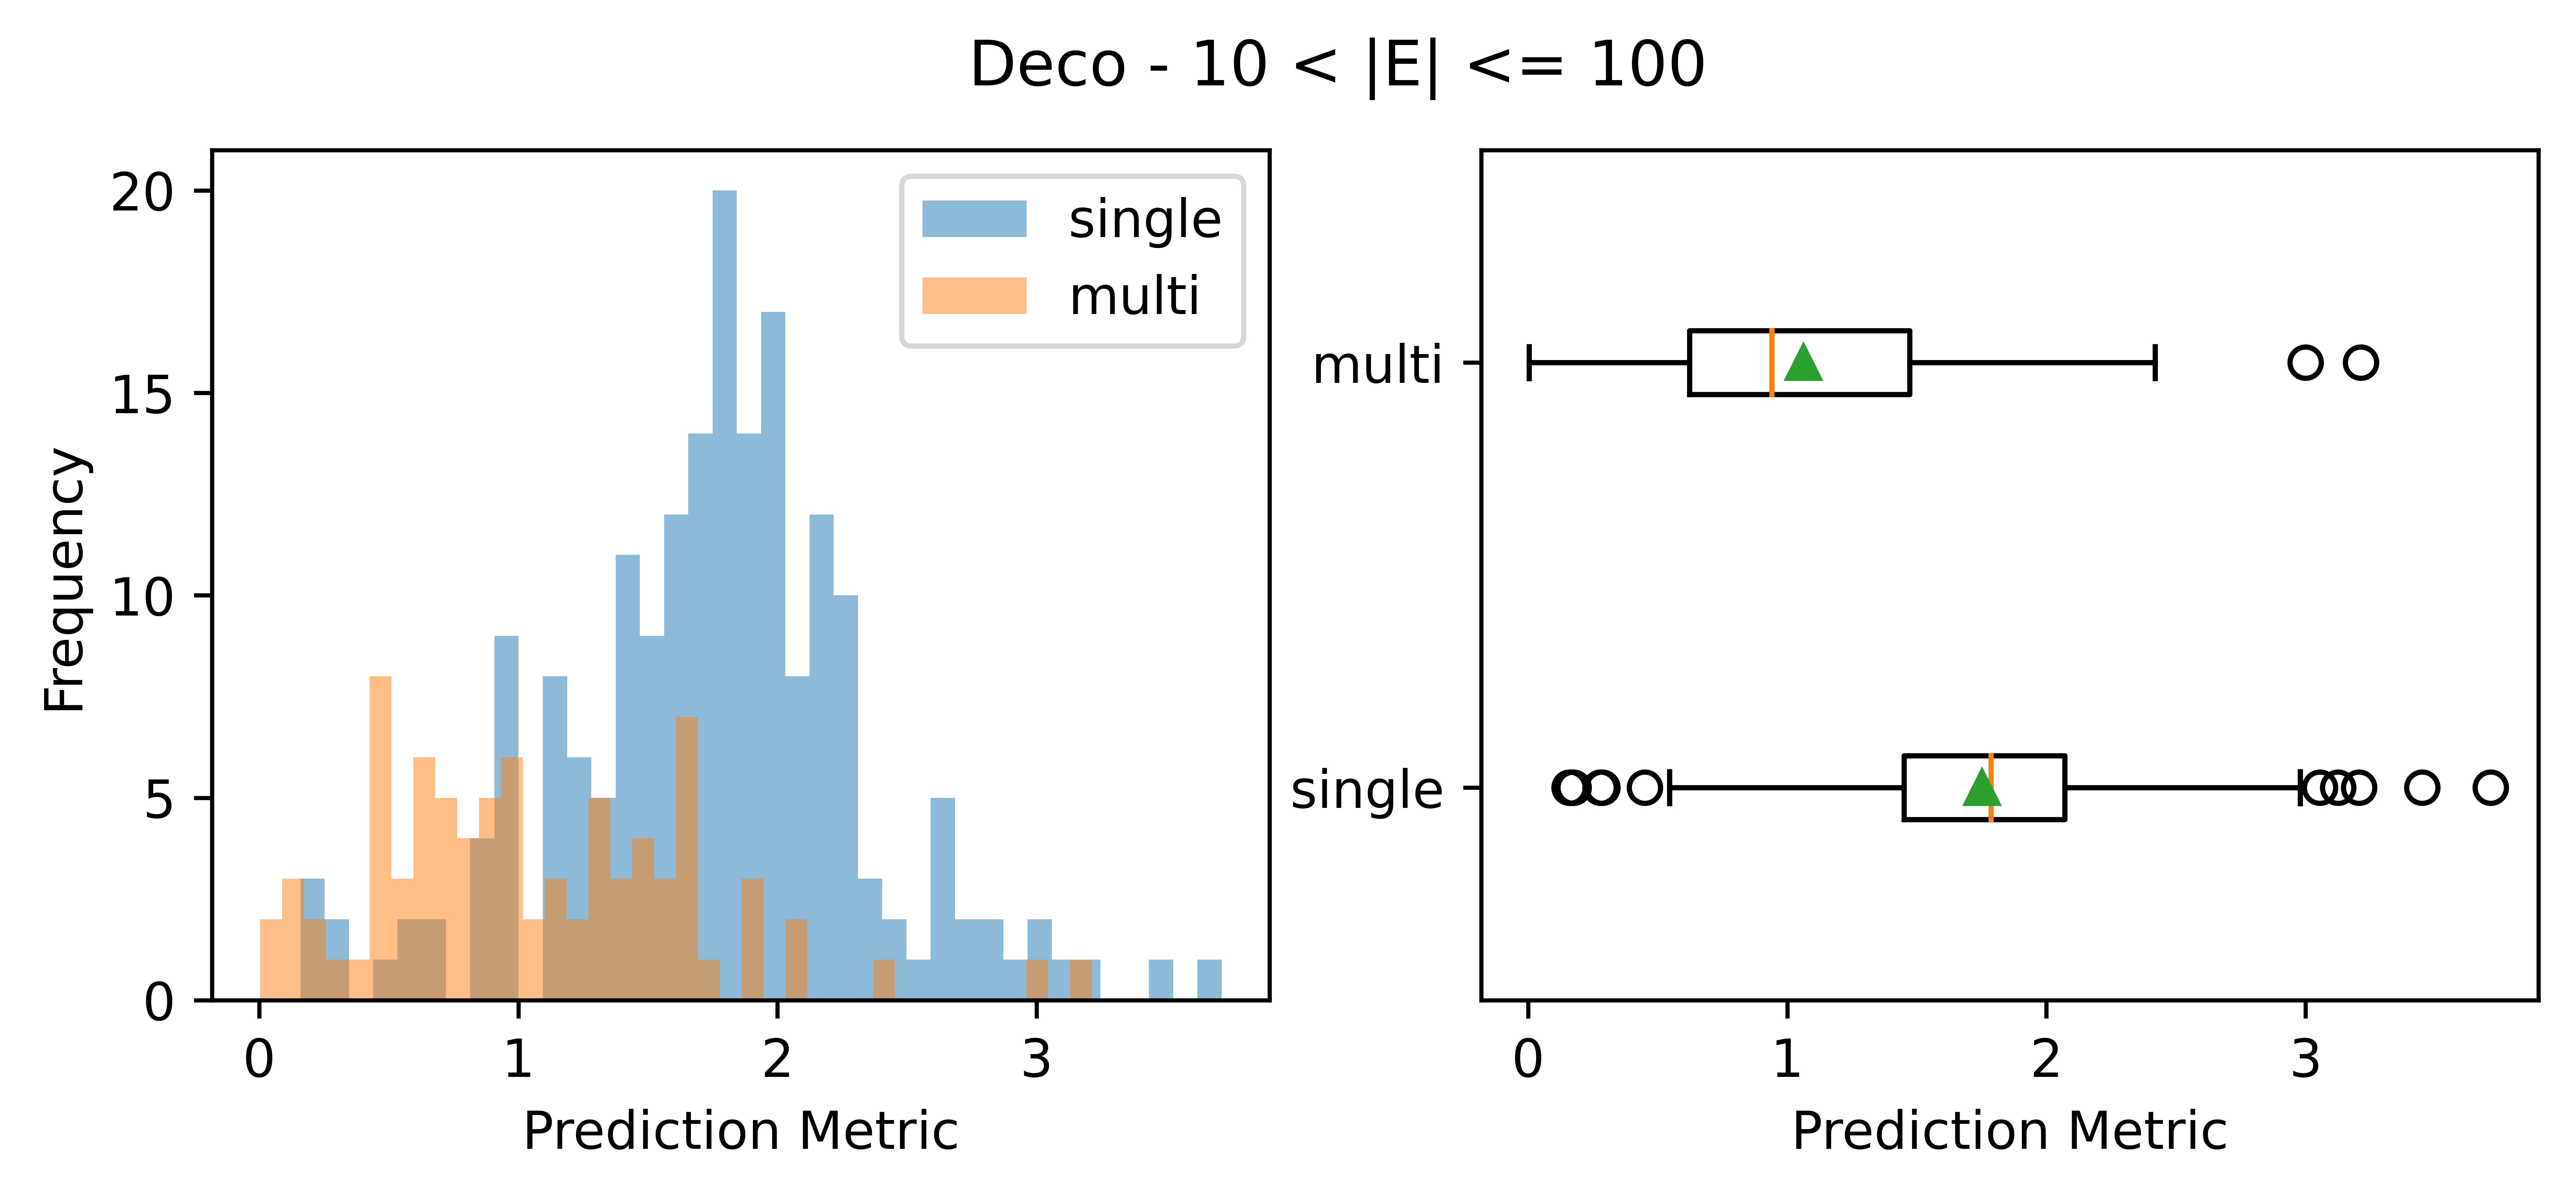

In [23]:
graphs = deco_graphs
visualize_metric(lambda x: edges_b_10_100(x), "Deco - 10 < |E| <= 100")

1.6149870801033592
1.6551315272960305


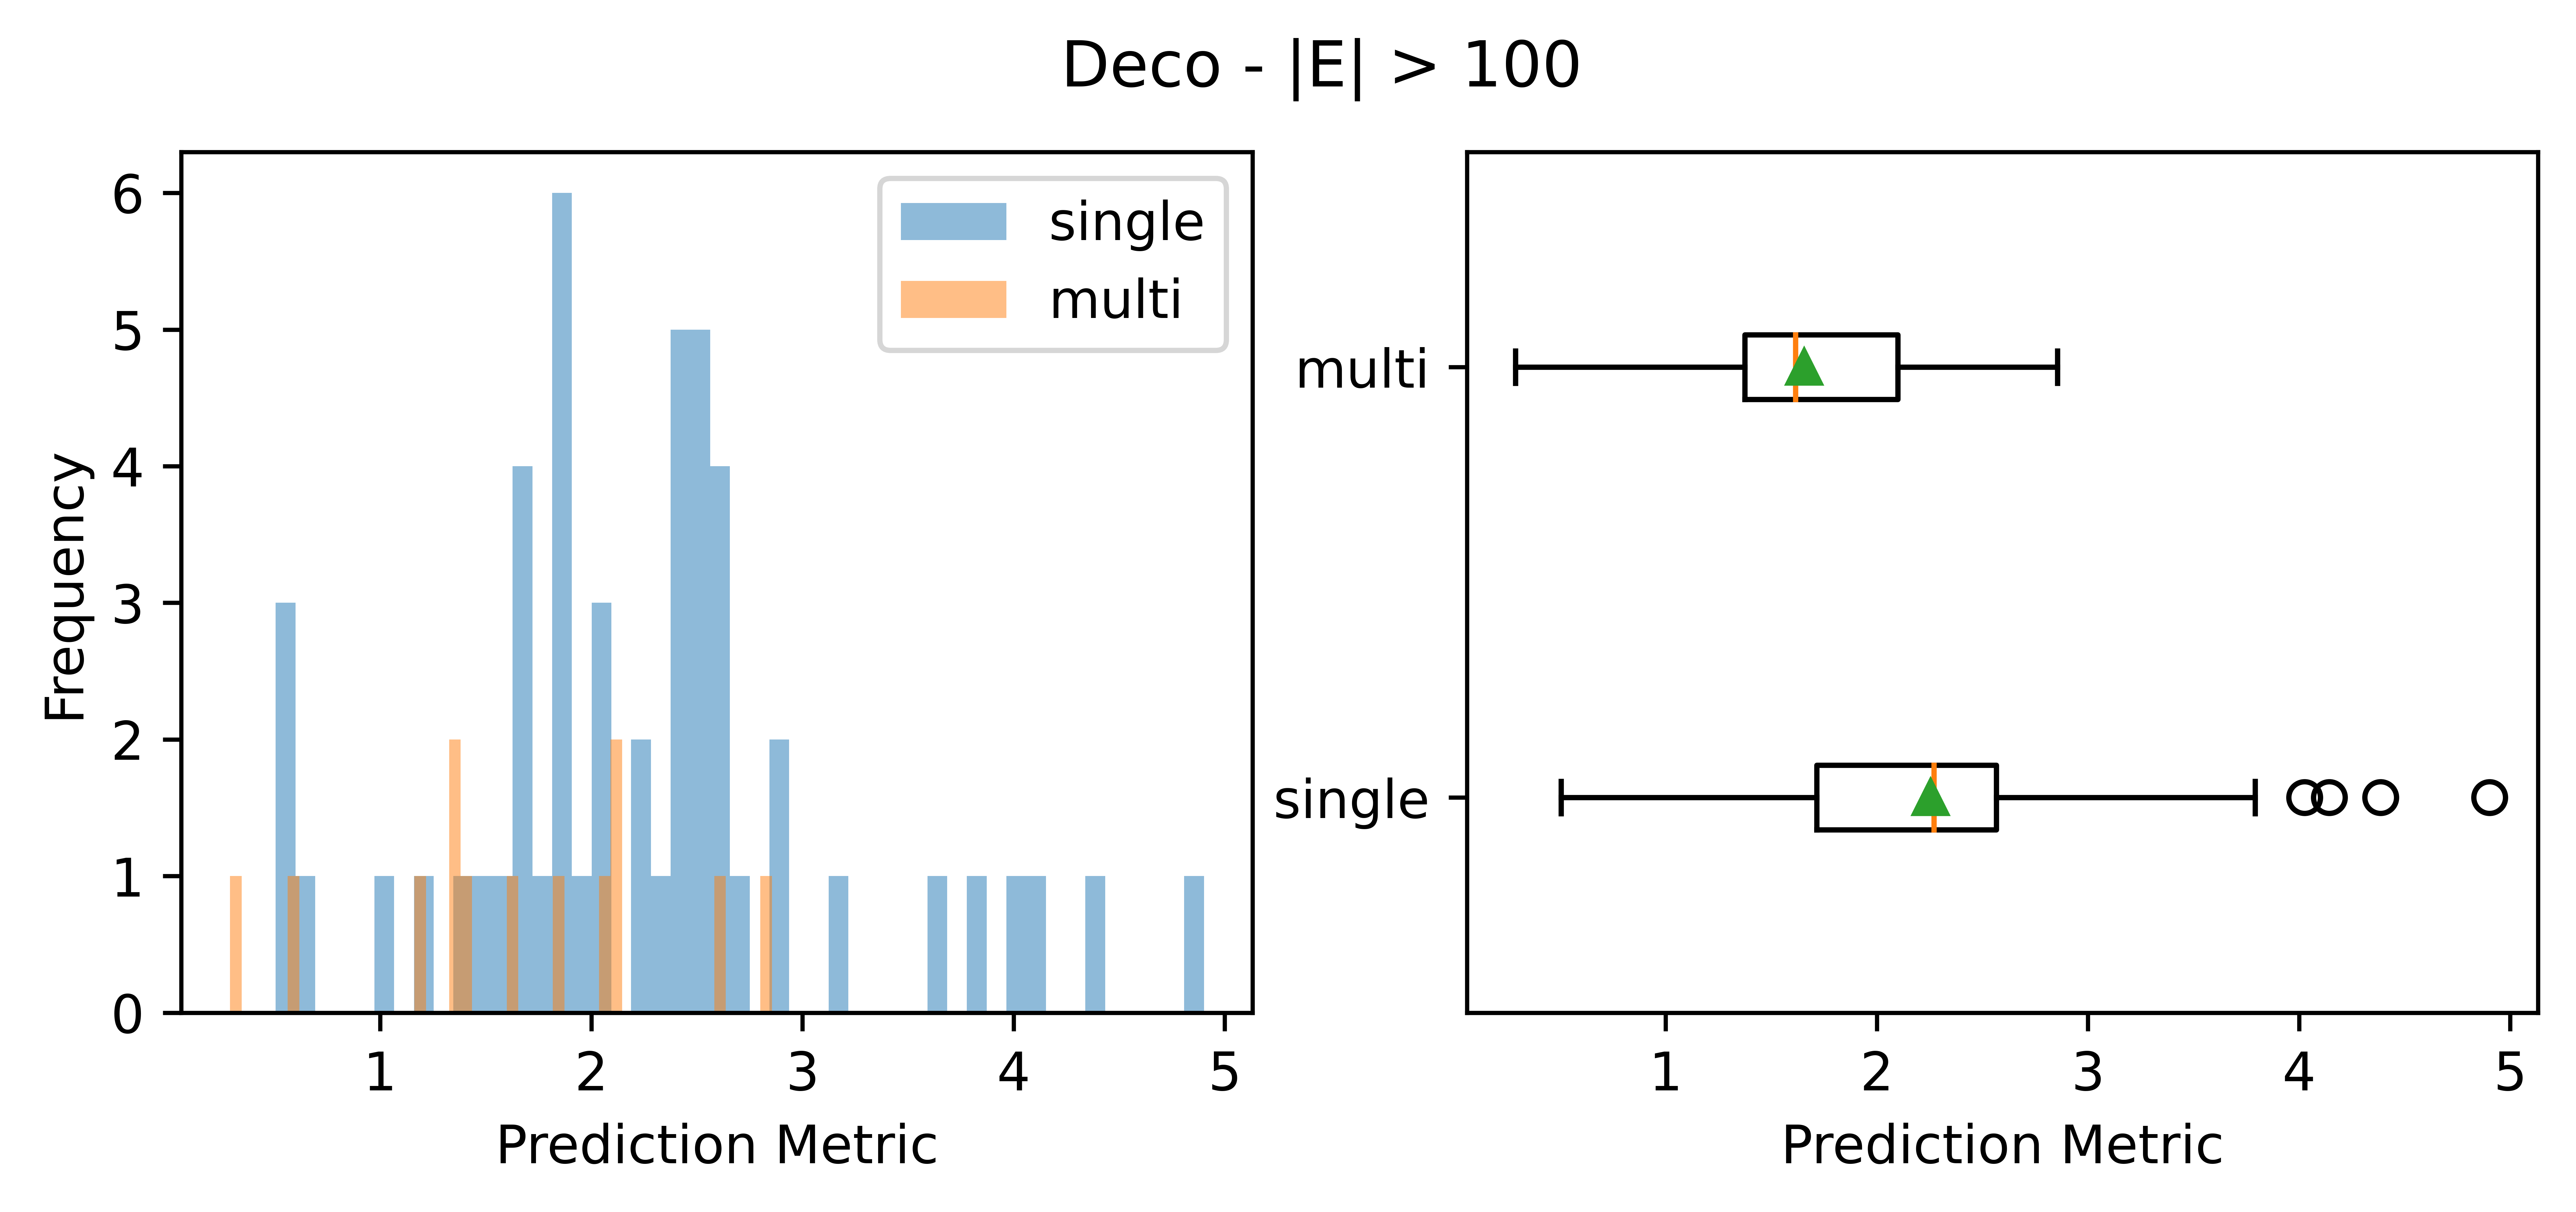

In [25]:
graphs = deco_graphs
visualize_metric(lambda x: edges_a_100(x), "Deco - |E| > 100")

1.1666666666666667
1.0723124469061949


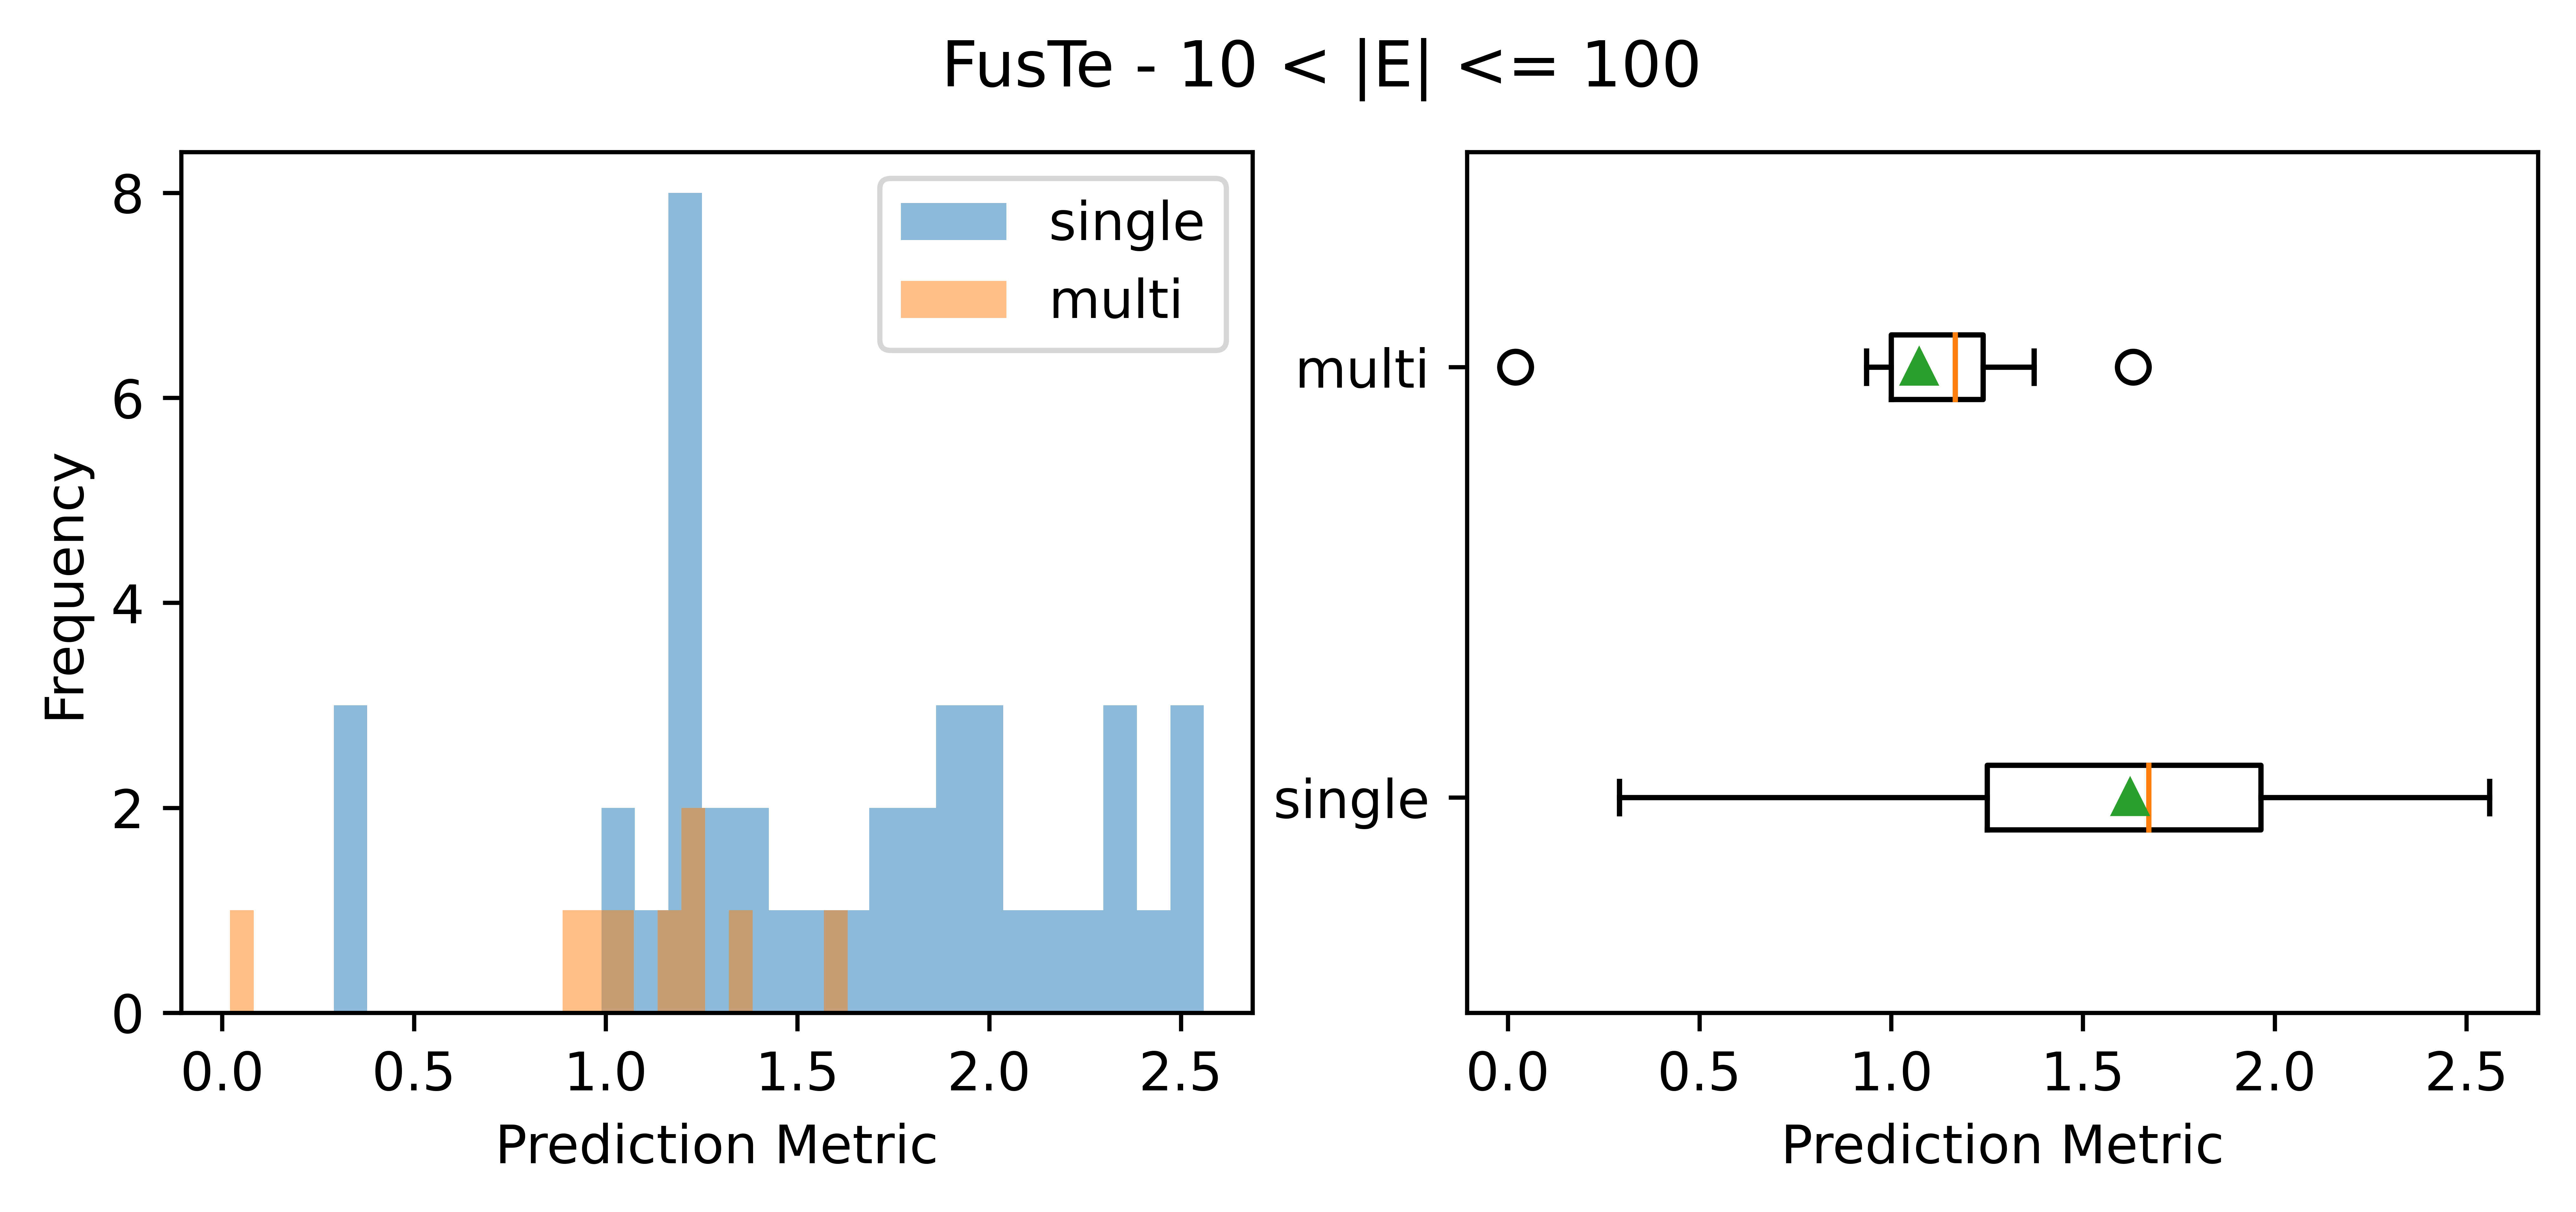

In [27]:
graphs = fuste_graphs
visualize_metric(lambda x: edges_b_10_100(x), "FusTe - 10 < |E| <= 100")

1.6944444444444442
1.6944444444444442


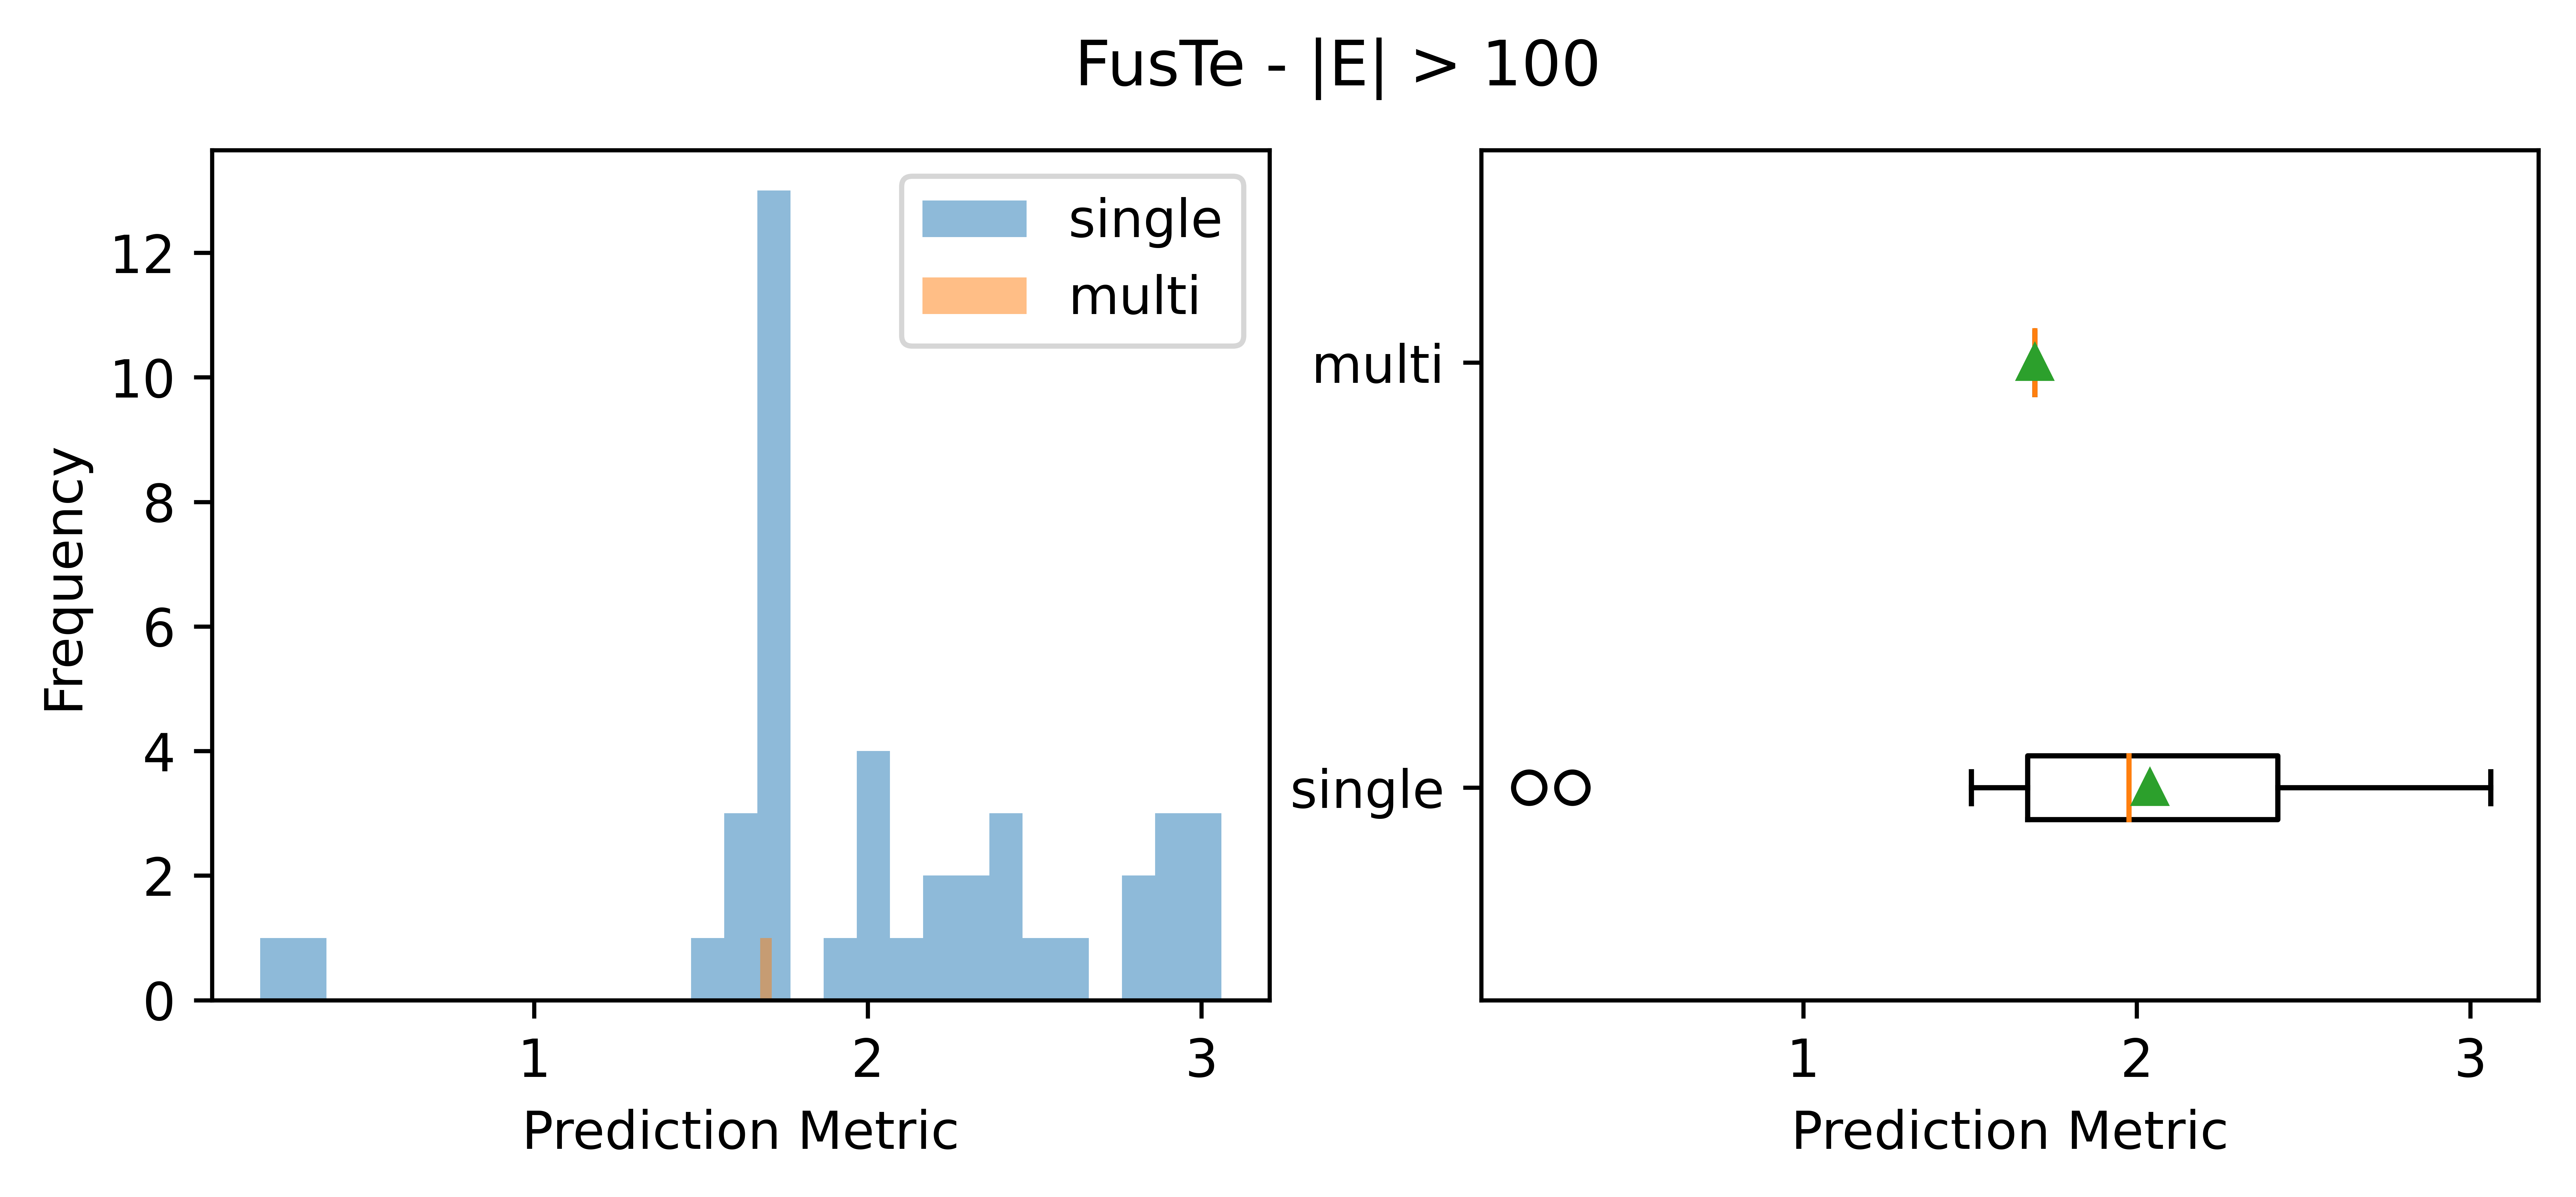

In [26]:
graphs = fuste_graphs
visualize_metric(lambda x: edges_a_100(x), "FusTe - |E| > 100")

In [13]:
from random import sample
from statistics import median

from labelregions.LabelRegionType import LabelRegionType

def eval_metric(bound):
    
    predict_multi = lambda g: prediction_metric(g) <= bound

    single_as_multi = 0
    multi_as_multi = 0

    total_single = 0
    total_multi = 0

    for g in graphs:
        if 10 < len(g.edge_list) <= 100:
            components = g.get_components()
            if len(components) == 1:
                # Single
                total_single += 1
                multi = predict_multi(g)
                if multi:
                    single_as_multi += 1
            else:
                # Multi
                total_multi += 1
                multi = predict_multi(g)
                if multi:
                    multi_as_multi += 1

    precision = multi_as_multi / (multi_as_multi + single_as_multi)
    recall = multi_as_multi / total_multi

    # print(single_as_multi)
    print(f"Percent of singles predcited as multi: {single_as_multi / total_single:.4f}")
    # print(multi_as_multi)
    print(f"Percent of multi predcited as multi: {multi_as_multi / total_multi:.4f}")

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    f1 = 2 * precision * recall
    f1 /= precision + recall
    print(f"F1: {f1}")
        


In [14]:
eval_metric(0.8)

Percent of singles predcited as multi: 0.0732
Percent of multi predcited as multi: 0.1111
Precision: 0.25
Recall: 0.1111111111111111
F1: 0.15384615384615383


In [15]:
import random


def get_folds(fold_num):
    multi_graphs = [g for g in graphs if len(g.get_components()) > 1]
    single_graphs = [g for g in graphs if len(g.get_components()) == 1]
    print(len(multi_graphs))
    print(len(single_graphs))
    
    folds = []
    for _ in range(fold_num):
        test_single = random.sample(single_graphs, int(len(single_graphs) / fold_num))
        test_multi = random.sample(multi_graphs, int(len(multi_graphs) / fold_num))
        test = test_single + test_multi
        train = [g for g in graphs if g not in test]
        folds.append((test, train))
    return folds
    
def eval_with_folds(fold_num):
    folds = get_folds(fold_num)
        
    f1_s = []
    for i, (test, train) in enumerate(folds):
        print(f"Fold {i}")
        # Train: Get median of multi-table
        multi = [g for g in train if len(g.get_components()) > 1]
        results = [prediction_metric(g) for g in multi]
        multi_median = median(results)
        
        # Test: Calc f1 against test set
        f1 = eval_metric(test, multi_median)
        f1_s.append(f1)

def eval_metric(test, bound):
    
    predict_multi = lambda g: prediction_metric(g) < bound

    single_as_multi = 0
    multi_as_multi = 0

    total_single = 0
    total_multi = 0

    for g in test:
        if 10 < len(g.edge_list) <= 100:
            components = g.get_components()
            if len(components) == 1:
                # Single
                total_single += 1
                multi = predict_multi(g)
                if multi:
                    single_as_multi += 1
            else:
                # Multi
                total_multi += 1
                multi = predict_multi(g)
                if multi:
                    multi_as_multi += 1
    


    # print(single_as_multi)
    print(f"Percent of singles predcited as multi: {single_as_multi / total_single:.4f}")
    if multi_as_multi == 0:
        return 0
    # print(multi_as_multi)
    print(f"Percent of multi predcited as multi: {multi_as_multi / total_multi:.4f}")
    

    precision = multi_as_multi / (multi_as_multi + single_as_multi)
    recall = multi_as_multi / total_multi
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    f1 = 2 * precision * recall
    f1 /= precision + recall
    print(f"F1: {f1}")
    return f1
        


In [16]:
eval_with_folds(10)

181
253
Fold 0
Percent of singles predcited as multi: 0.0000
Fold 1
Percent of singles predcited as multi: 0.0000
Percent of multi predcited as multi: 0.5000
Precision: 1.0
Recall: 0.5
F1: 0.6666666666666666
Fold 2
Percent of singles predcited as multi: 0.0000
Fold 3
Percent of singles predcited as multi: 0.0000
Fold 4
Percent of singles predcited as multi: 0.0000
Fold 5
Percent of singles predcited as multi: 0.0000
Fold 6
Percent of singles predcited as multi: 0.0000
Fold 7
Percent of singles predcited as multi: 0.0000
Fold 8
Percent of singles predcited as multi: 0.0000
Fold 9
Percent of singles predcited as multi: 0.0000


# Plot fold multi-single table distirbutions

181
253


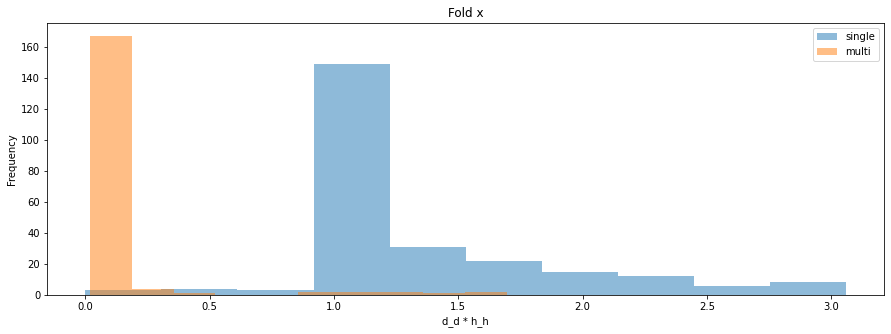

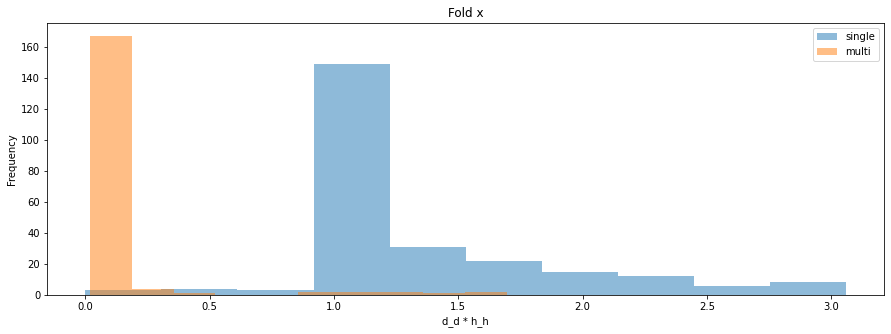

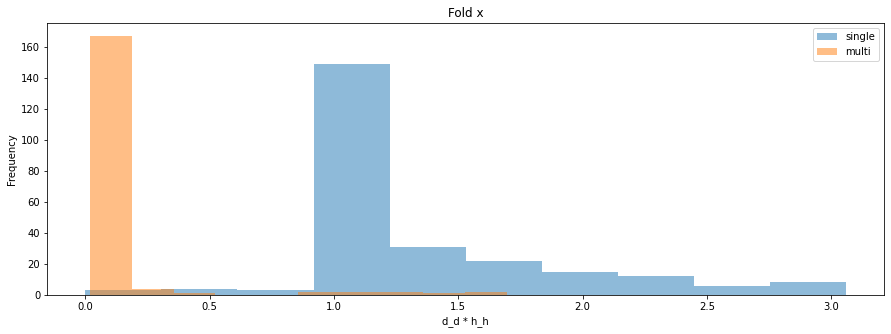

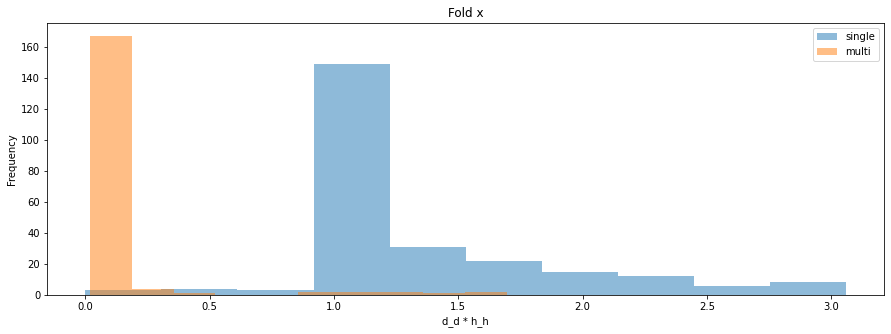

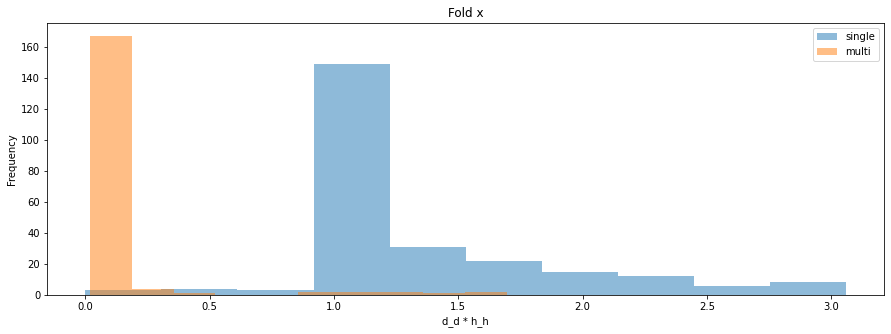

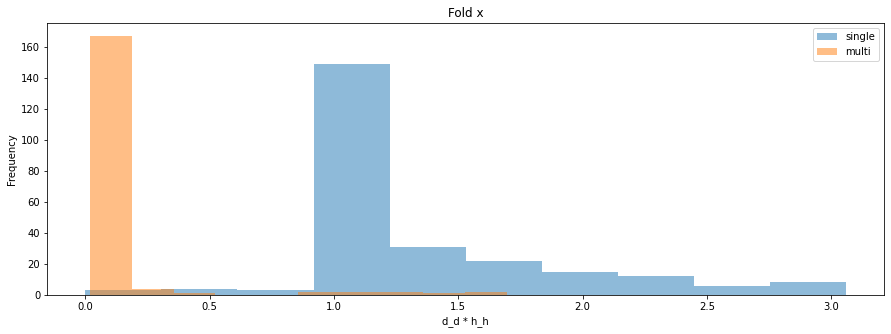

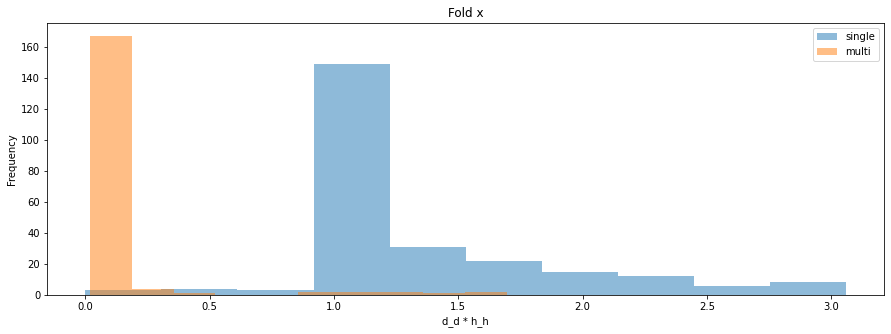

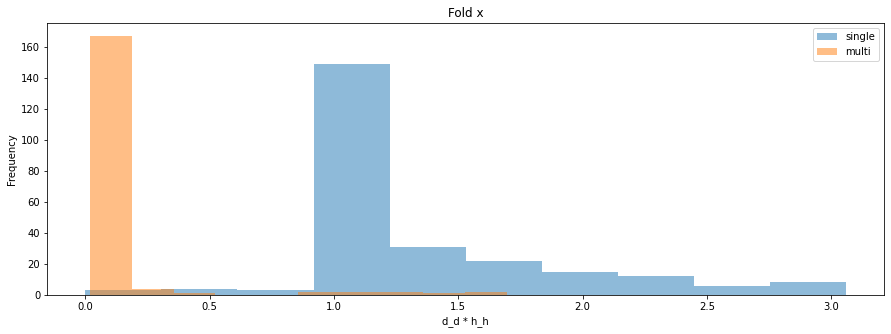

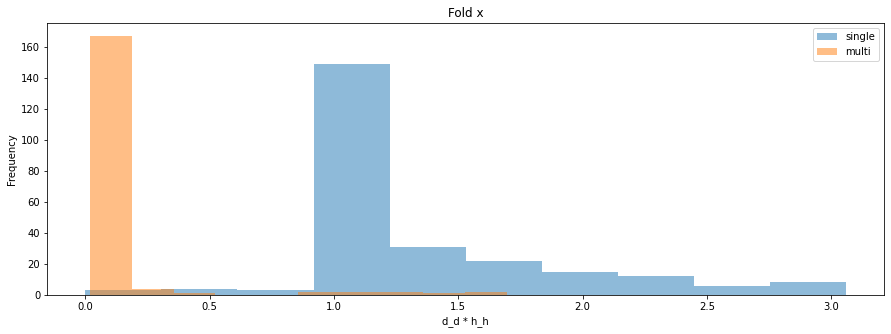

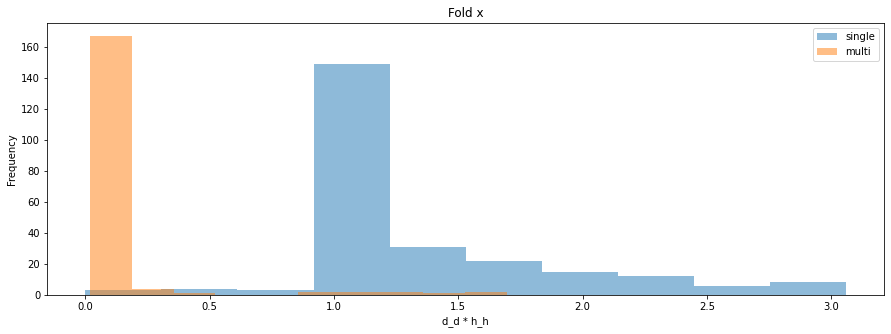

In [17]:
for fold in get_folds(10):
    # Unite train and test
    files = fold[0] + fold[1]
    
    
    single_agg = []
    multi_agg = []
    for g in graphs:
        if True or 10 < len(g.edge_list) <= 100:
            m = prediction_metric(g)
            if len(g.get_components()) == 1:
                single_agg.append(m)
            else:
                multi_agg.append(m)
    
    fig, ax1 = plt.subplots(1,1, figsize=(15, 5))
    ax1.hist(single_agg, label="single", alpha=0.5)
    ax1.hist(multi_agg, label="multi", alpha=0.5)
    ax1.legend()
    ax1.set_ylabel("Frequency")
    ax1.set_xlabel("d_d * h_h")
    ax1.set_title("Fold x")